In [40]:
import torch
print(torch.cuda.is_available())  # 输出True才能使用GPU加速
print(torch.__version__)  # 需要1.6+版本，请根据自己电脑的GPU下载相应的版本

True
2.5.1+cu121


Initial Acc: 0.0869
Epoch  0 | Acc: 0.9718 | Time: 11.02s
Epoch  1 | Acc: 0.9789 | Time: 4.26s
Epoch  2 | Acc: 0.9816 | Time: 4.50s
Epoch  3 | Acc: 0.9850 | Time: 4.29s
Epoch  4 | Acc: 0.9852 | Time: 4.36s
Epoch  5 | Acc: 0.9875 | Time: 4.45s
Epoch  6 | Acc: 0.9862 | Time: 4.44s
Epoch  7 | Acc: 0.9886 | Time: 4.23s
Epoch  8 | Acc: 0.9886 | Time: 4.30s
Epoch  9 | Acc: 0.9882 | Time: 4.50s
图像数据范围: [-0.424, 2.821]
图像数据范围: [-0.424, 2.821]
图像数据范围: [-0.424, 2.821]
图像数据范围: [-0.424, 2.821]


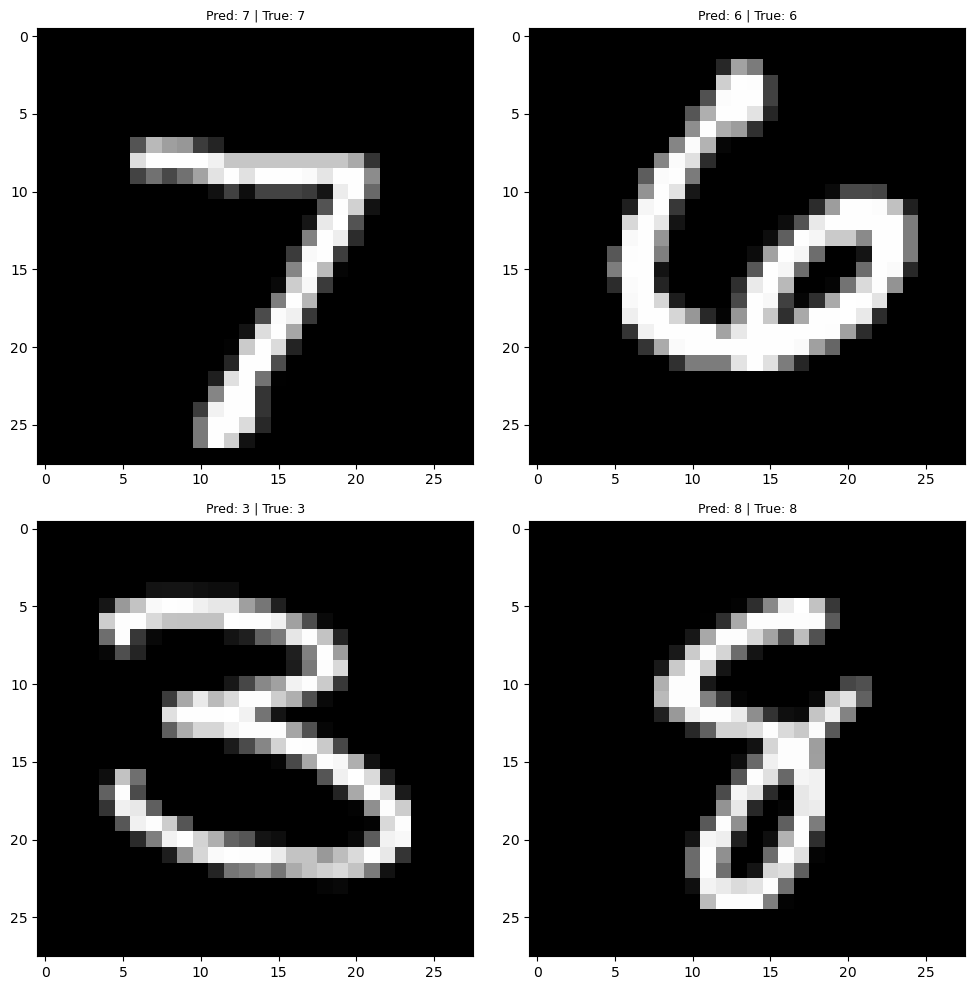

In [38]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(1600, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        # 保持原始前向传播逻辑
        x = x.view(-1, 1, 28, 28)
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def get_data_loader(is_train):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    if is_train:
        transform.transforms.insert(0, transforms.RandomRotation(10))
    return DataLoader(
        datasets.MNIST("", train=is_train, transform=transform, download=True),
        batch_size=200,  # 增大批大小，可以自己调整，只要内核不崩就行
        shuffle=True if is_train else False,
        num_workers=4,    # 多进程加载，相比于cpu的优势！
        pin_memory=True,    # 锁页内存加速GPU传输
        persistent_workers=True   # 保持worker进程
    )

def evaluate(test_data, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_data:
            x, y = x.to(device), y.to(device)  # 数据转移
            outputs = net(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total

def main():
    # 数据加载
    train_data = get_data_loader(is_train=True)
    test_data = get_data_loader(is_train=False)
    
    # 模型初始化
    net = Net().to(device)
    initial_acc = evaluate(test_data, net)
    print(f"Initial Acc: {initial_acc:.4f}")  # 初始准确率应接近0.1（随机猜测）
    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)

    # 训练循环
    # 在训练循环中修改数据转移
    for epoch in range(10):
        epoch_start = time.time() 
        net.train()
        for x, y in train_data:
            x, y = x.to(device), y.to(device)  # 数据转移
        
            optimizer.zero_grad()
            outputs = net(x)  # 此时x已在GPU
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

        acc = evaluate(test_data, net)
        epoch_time = time.time() - epoch_start
        scheduler.step(acc)
        print(f"Epoch {epoch:2d} | Acc: {acc:.4f} | Time: {epoch_time:.2f}s")

    def cpu_visualization(model, test_loader):
        model.eval().cpu()    # 确保模型在CPU，之前直接在GPU上进行可视化导致崩溃，所以将可视化的步骤全部在CPU上操作
        plt.figure(figsize=(10, 10))
        
        with torch.no_grad():
            images, labels = next(iter(test_loader))
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            
            for i in range(4):
                img = images[i].squeeze()
                img = img * 0.3081 + 0.1307  # 自动执行逆标准化
                
                plt.subplot(2, 2, i+1)
                plt.imshow(img.numpy(), cmap='gray')
                plt.title(f"Pred: {preds[i].item()}")
        
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = Net().to(device)
    
    # 训练并保存
    main()
    
    # 直接加载并可视化
    net.load_state_dict(torch.load("mnist_model.pth", weights_only=True))
    cpu_visualization(net, get_data_loader(is_train=False))